<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_lectures/blob/main/HW_2_5_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передбачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Завантаження даних
path = "https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/demand-forecasting-kernels-only_train.csv"
data = pd.read_csv(path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

display(data.tail(10))

,store,item,sales
date,,,
2017-12-22,10,50,75
2017-12-23,10,50,70
2017-12-24,10,50,76
2017-12-25,10,50,51
2017-12-26,10,50,41
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



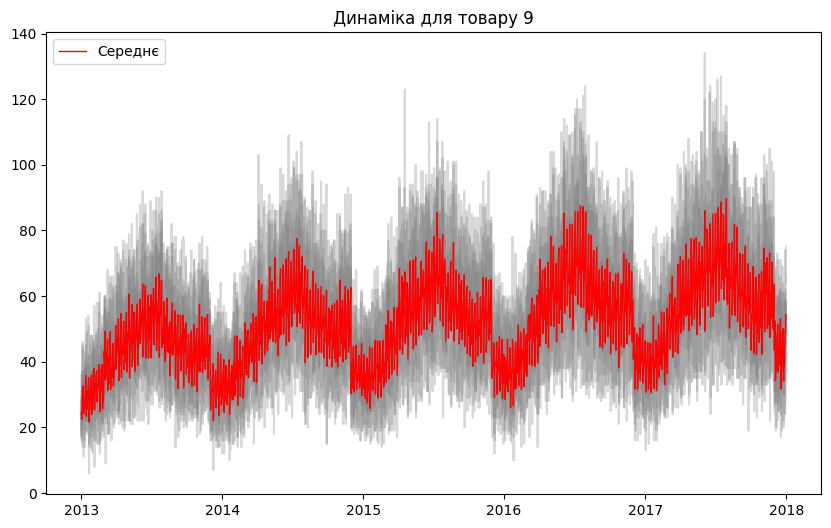

In [3]:
item_id = 9
df_item = data[data["item"] == item_id]

fig, ax = plt.subplots(figsize=(10,6))

for store_id, group in df_item.groupby("store"):
    ax.plot(group.index, group["sales"], color="gray", alpha=0.3)

mean_sales = df_item.groupby(df_item.index)["sales"].mean()
ax.plot(mean_sales.index, mean_sales.values, color="red", linewidth=1, label="Середнє")

ax.set_title(f"Динаміка для товару {item_id}")
ax.legend()
plt.show()

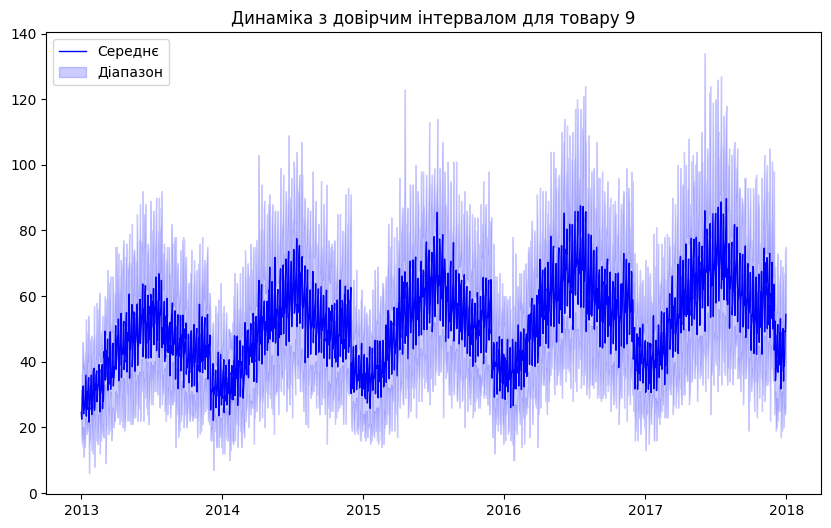

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

item_id = 9

df_item = data[data["item"] == item_id]

stats = df_item.groupby("date")["sales"].agg(["mean", "min", "max"])

ax.plot(stats.index, stats["mean"], color="blue", linewidth=1, label="Середнє")
ax.fill_between(stats.index, stats["min"], stats["max"], color="blue", alpha=0.2, label="Діапазон")

ax.set_title(f"Динаміка з довірчим інтервалом для товару {item_id}")
ax.legend()
plt.show()

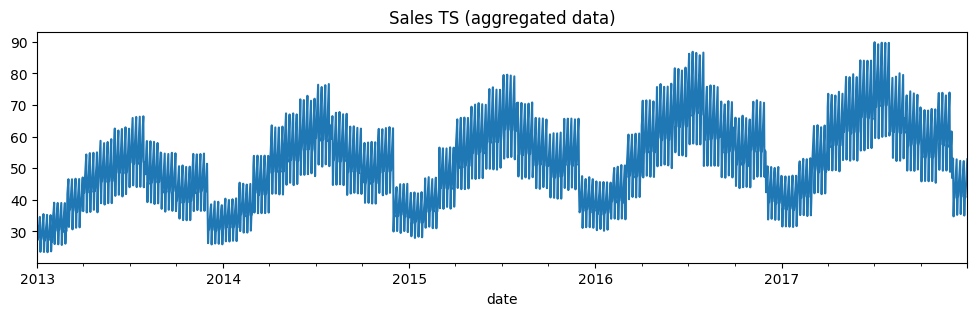

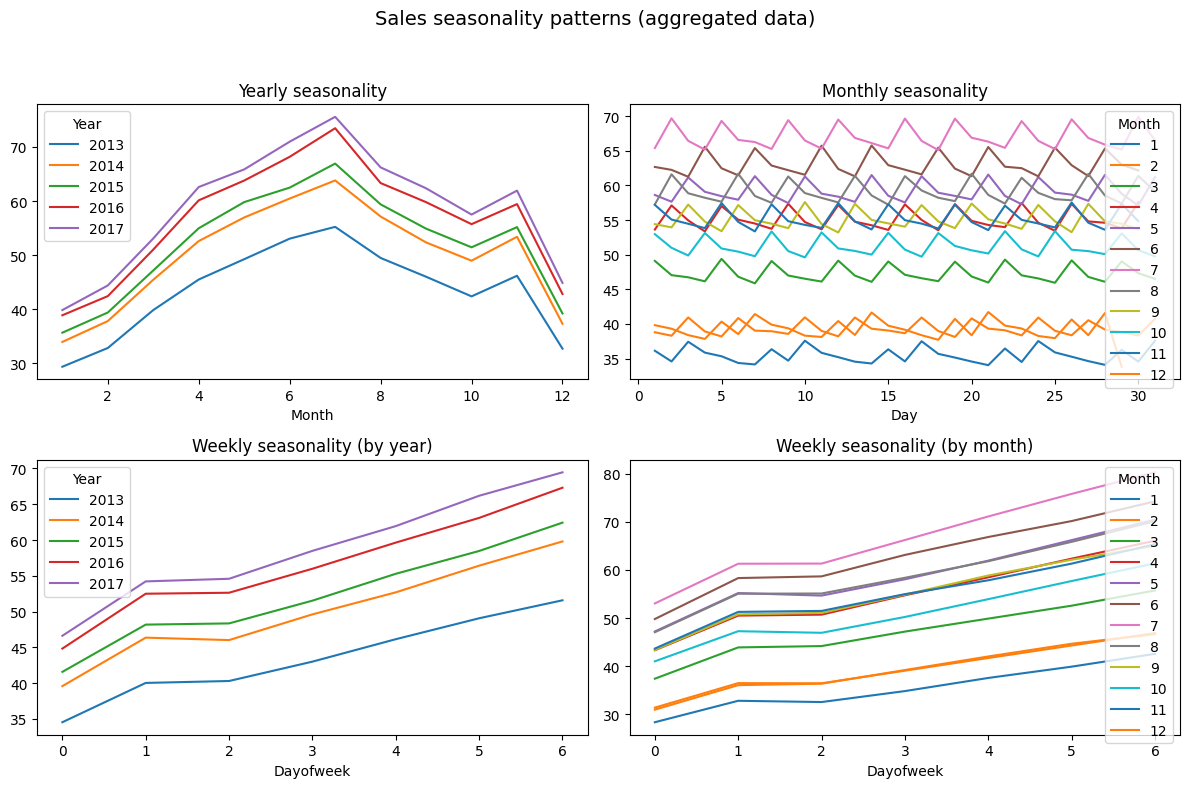

In [5]:
# Створюємо додаткові змінні з дати
df_trainext = data.copy()
df_trainext['Year'] = df_trainext.index.year
df_trainext['Month'] = df_trainext.index.month
df_trainext['Day'] = df_trainext.index.day
df_trainext['Dayofweek'] = df_trainext.index.dayofweek  # 0=Mon, 6=Sun

# -------------------------------
# 1. Загальний часовий ряд
# -------------------------------
df_trainext['sales'].resample('D').mean().plot(
    figsize=(12,3),
    title='Sales TS (aggregated data)'
)
plt.show()

# -------------------------------
# 2–5. Сезонність
# -------------------------------
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Річна сезонність
pd.pivot_table(
    df_trainext, values='sales',
    index='Month', columns='Year',
    aggfunc='mean'
).plot(ax=ax[0,0], title="Yearly seasonality")

# Місячна сезонність
pd.pivot_table(
    df_trainext, values='sales',
    index='Day', columns='Month',
    aggfunc='mean'
).plot(ax=ax[0,1], title="Monthly seasonality")

# Тижнева сезонність (по роках)
pd.pivot_table(
    df_trainext, values='sales',
    index='Dayofweek', columns='Year',
    aggfunc='mean'
).plot(ax=ax[1,0], title="Weekly seasonality (by year)")

# Тижнева сезонність (по місяцях)
pd.pivot_table(
    df_trainext, values='sales',
    index='Dayofweek', columns='Month',
    aggfunc='mean'
).plot(ax=ax[1,1], title="Weekly seasonality (by month)")

fig.suptitle('Sales seasonality patterns (aggregated data)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Лінійний графік — щоденна динаміка продажів (усереднена по магазинах/товарах).

Yearly seasonality — для кожного року, як протягом місяців змінюються продажі.

Monthly seasonality — для кожного місяця показано профіль "по днях місяця".

Weekly (by year) — тижнева структура продажів (понеділок–неділя) для різних років.

Weekly (by month) — тижнева структура продажів для різних місяців.

**Висновки**:

Yearly seasonality  - від подчатку року продажі зростають, найбільші в липні, потім починають зменшуватися і невелике зростання прослідковується у листопаді.

Monthly seasonality  - протягом місяця, в залежності від дня динаміка продажів також змінюється, про що свідчать графіки Weekly (by year) та  Weekly (by month), від початку тижня продажі ростуть і досягають максимуму у неділю.

Також кожного року спостерігається різке зниження продажів з листопада на грудень - схоже на реакцію після розпродажу на Чорну п'ятницю в кінці листопада.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [6]:
data_store1_item1= data[(data.item == 1) & (data.store == 1)].sales.to_frame()

In [7]:
# Графік не відобразиться на GitHub
fig = px.line(data_store1_item1, y='sales')

fig.update_traces(line=dict(color='#7BC8F6', width=2), showlegend=False)

fig.update_layout(
    template="simple_white",
    font=dict(size=18),
    title_text='Sales',
    title_x=0.5,
    width=800,
    height=500,
    xaxis_title="Date",
    yaxis_title="Sales",
    xaxis=dict(
        showgrid=True, gridcolor='lightgray', gridwidth=0.5,
        mirror=True, linecolor='black', linewidth=1
    ),
    yaxis=dict(
        showgrid=True, gridcolor='lightgray', gridwidth=0.5,
        mirror=True, linecolor='black', linewidth=1
    ),
    margin=dict(l=50, r=30, t=60, b=50)
)

fig.show()

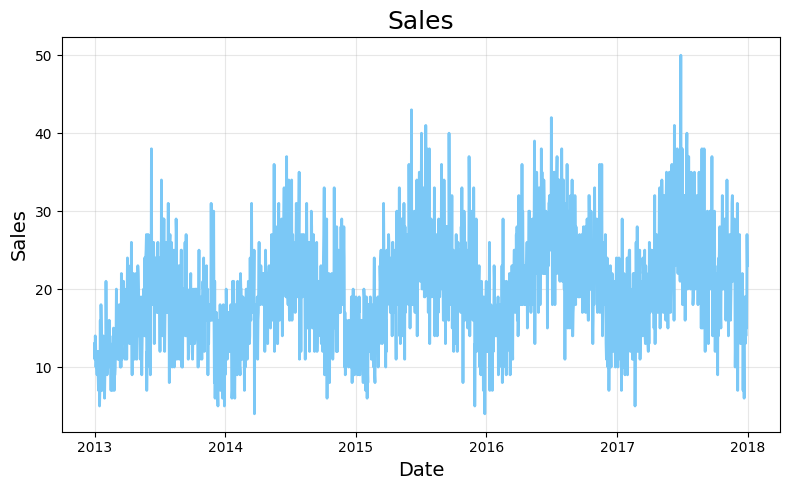

In [8]:
plt.figure(figsize=(8, 5))  # ширина=8 дюймів, висота=5 дюймів
plt.plot(data_store1_item1.index, data_store1_item1.values, color='#7BC8F6', linewidth=2)
plt.title('Sales', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
df_additive = data_store1_item1.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром
df_additive["trend"] = df_additive['sales'].rolling(window=365, center=True).mean()

# віднімаємо тренд з даних
df_additive["detrended"] = df_additive['sales'] - df_additive["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_additive["month"] = df_additive.index.month
df_additive["seasonality"] = df_additive.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_additive["resid"] = df_additive["detrended"] - df_additive["seasonality"]

# що у нас вийшло в результаті
df_additive.sample(5)


,sales,trend,detrended,month,seasonality,resid
date,,,,,,
2014-07-11,25,18.893151,6.106849,7,6.046159,0.060690
2014-03-11,14,18.460274,-4.460274,3,-2.320482,-2.139792
2013-08-23,19,16.969863,2.030137,8,2.176513,-0.146376
2013-09-23,18,17.213699,0.786301,9,0.922352,-0.136050
2014-03-27,17,18.504110,-1.504110,3,-2.320482,0.816372


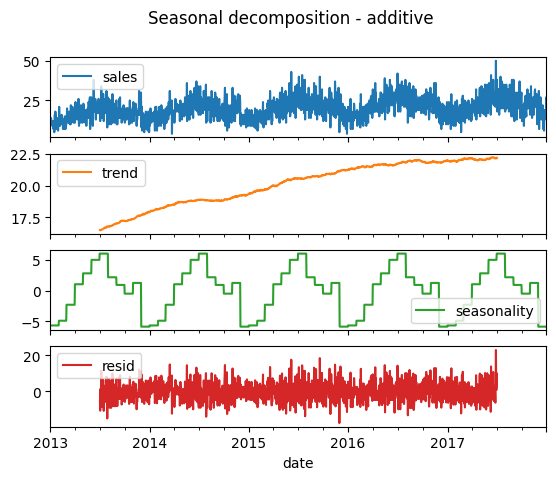

In [10]:
(
    df_additive
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

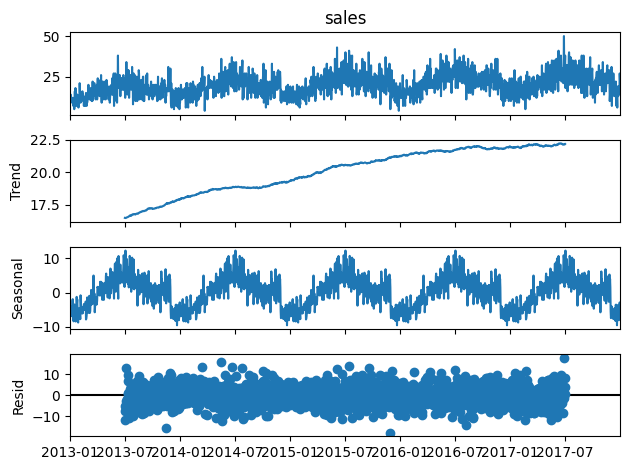

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(data_store1_item1['sales'],
                                              model='additive', period=365)#, period=365)
decomposition_plot_multi.plot()
plt.show()

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [12]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
data_store1_item1.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [14]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(data_store1_item1, value_cols = 'sales')

In [15]:
series

<TimeSeries (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='date'>

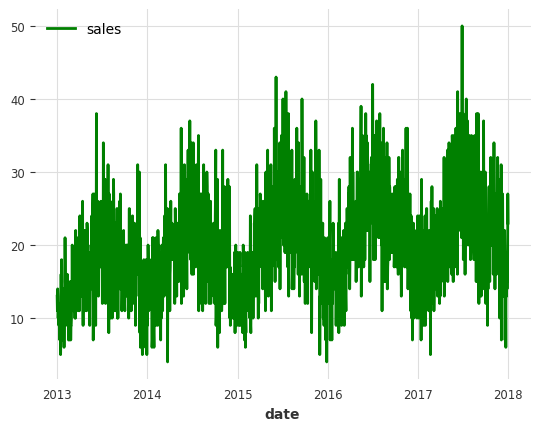

In [16]:
series.plot(color = 'green')

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

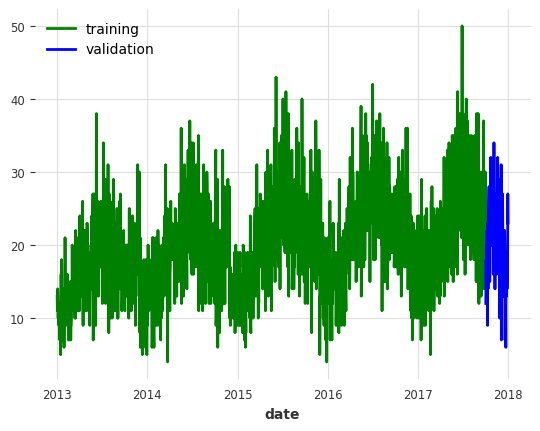

In [17]:
split_time = pd.Timestamp('2017-10-01')
series_train, series_val = series.split_after(split_time)
series_train.plot(label = 'training', color = 'green')
series_val.plot(label = 'validation', color = 'blue')

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

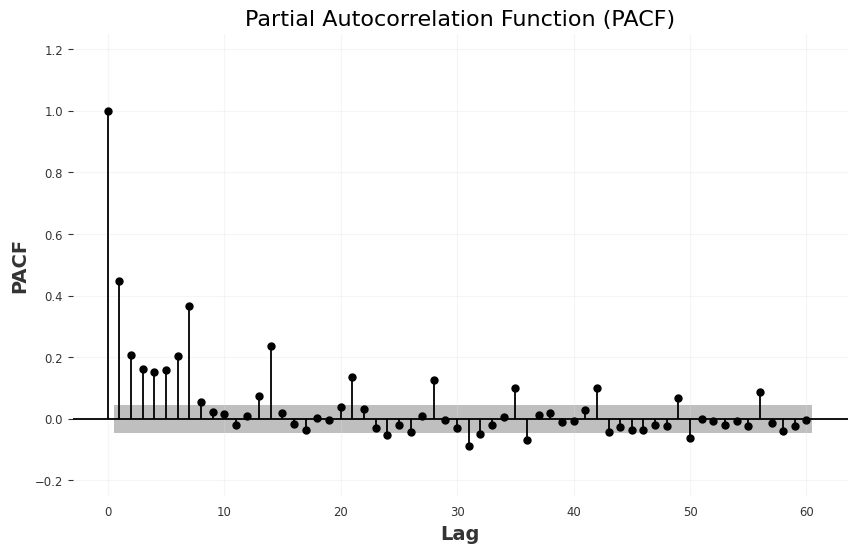

In [19]:
# перетворюємо TimeSeries у pandas
series_pd = series.to_dataframe().iloc[:, 0]

from statsmodels.graphics.tsaplots import plot_pacf, pacf
nlags = 60

fig, ax = plt.subplots(figsize=(10,6))
plot_pacf(series_pd, lags=nlags, method="ywm", ax=ax)

ax.set_title("Partial Autocorrelation Function (PACF)", fontsize=16)
ax.set_xlabel("Lag", fontsize=14)
ax.set_ylabel("PACF", fontsize=14)
ax.set_ylim(-0.25, 1.25)
ax.grid(True, alpha=0.3)

plt.show()

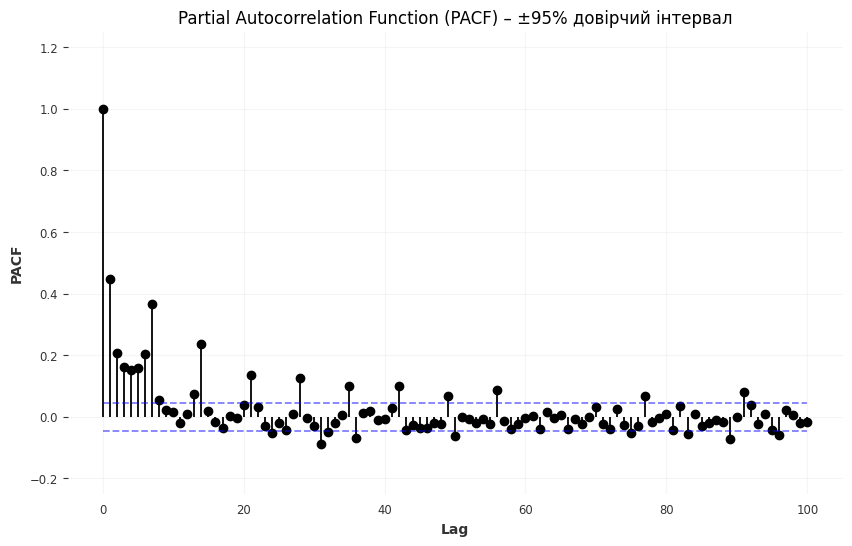

Значущі лаги: [ 0  1  2  3  4  5  6  7  8 13 14 21 24 28 31 32 35 36 42 49 50 56 75 77
 83 89 91 96]


In [20]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

series_pd = series.to_dataframe().iloc[:, 0]
n = len(series_pd)
nlags = 100

# обчислюємо PACF через plot_pacf без малювання
from statsmodels.tsa.stattools import pacf
pacf_values = pacf(series_pd, nlags=nlags, method="ywm")

# стандартні 95% довірчі інтервали
conf = 1.96/np.sqrt(n)

# графік
plt.figure(figsize=(10,6))
plt.stem(np.arange(nlags+1), pacf_values, basefmt=" ")
plt.hlines([conf, -conf], 0, nlags, colors='blue', linestyles='dashed', alpha=0.5)
plt.ylim(-0.25, 1.25)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.title("Partial Autocorrelation Function (PACF) – ±95% довірчий інтервал")
plt.grid(alpha=0.3)
plt.show()

# значущі лаги
lags = np.arange(len(pacf_values))
significant_lags = lags[(pacf_values > conf) | (pacf_values < -conf)]
print("Значущі лаги:", significant_lags)

**Висновок:**

З графіка часткової автокореляційної функції помітно, що важливими для прогнозування є лаги кратні семи.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

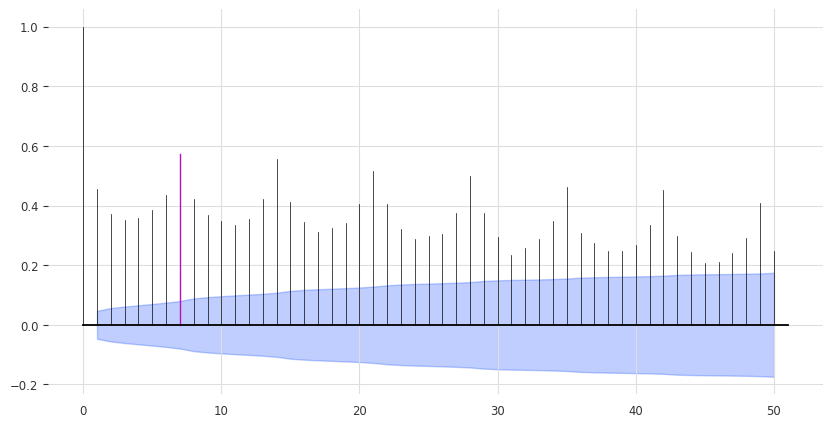

In [21]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(series_train, m=7, alpha=0.05, max_lag=50)

In [22]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7942e0e59440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


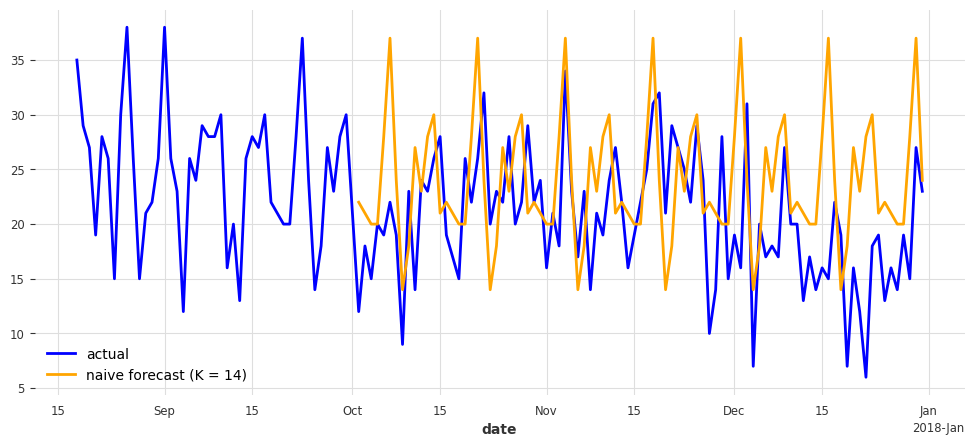

In [23]:
from darts.models import NaiveSeasonal
naive_model = NaiveSeasonal(K = 14)
naive_model.fit(series_train)
naive_forecast = naive_model.predict(len(series_val))

plt.figure(figsize=(12, 5))
series[int(-len(series_val) * 1.5):].plot(label = "actual", color = 'blue');
naive_forecast.plot(label = 'naive forecast (K = 14)', color = 'orange');
plt.show()

<Axes: xlabel='date'>

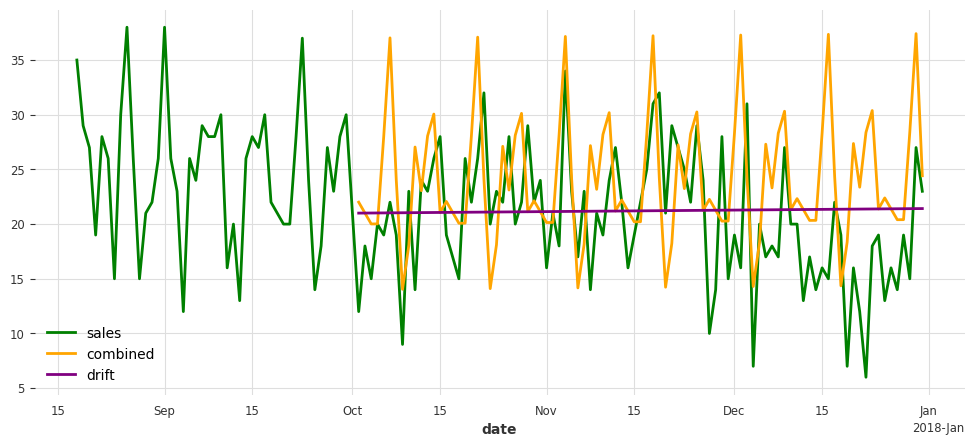

In [24]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(series_train)
drift_forecast = drift_model.predict(len(series_val))

combined_forecast = drift_forecast + naive_forecast - series_train.last_value()

plt.figure(figsize=(12, 5))
series[int(-len(series_val) * 1.5):].plot(color = 'green');
combined_forecast.plot(label = 'combined', color = 'orange');
drift_forecast.plot(label = 'drift', color = 'purple')

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [25]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series_val, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 40.50%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

Mean absolute percentage error for XGBoost: 28.36%.


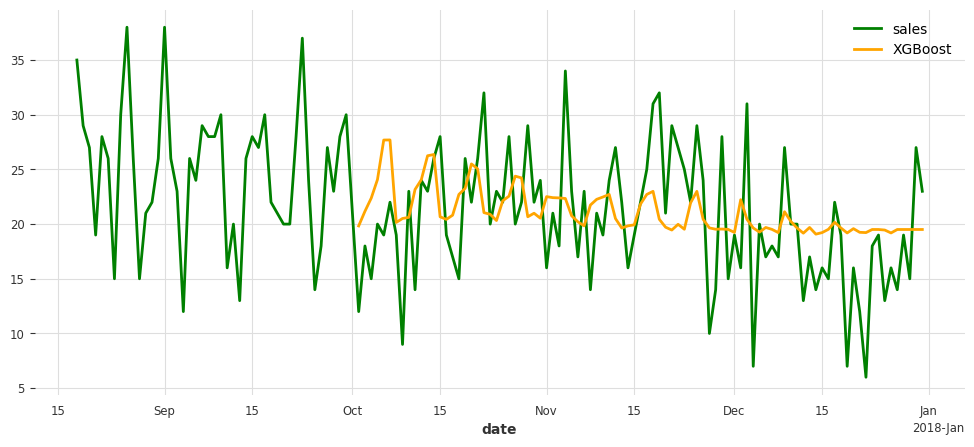

In [26]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  df["hour"] = df['date'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(series_train.to_dataframe().iloc[:, 0].reset_index())
val_transformed = enrich_with_date_features(series_val.to_dataframe().iloc[:, 0].reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(series_train)
test_transformed = scaler.transform(series_val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=12,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(series_train)
pred = model.predict(len(series_val))

plt.figure(figsize=(12, 5))
series[int(-len(series_val) * 1.5):].plot(color = 'green')
pred.plot(label = 'XGBoost', color = 'orange')

print(
    f"Mean absolute percentage error for XGBoost: {mape(series_val, pred):.2f}%."
)

**Висновок:**

XBGModel дає трохи кращі результати (MAPE: 28.36%), ніж combined naive drift + seasonal (MAPE: 40.50%). Моделі поки що не підходять для використання, оскільки значення помилки зависоке.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

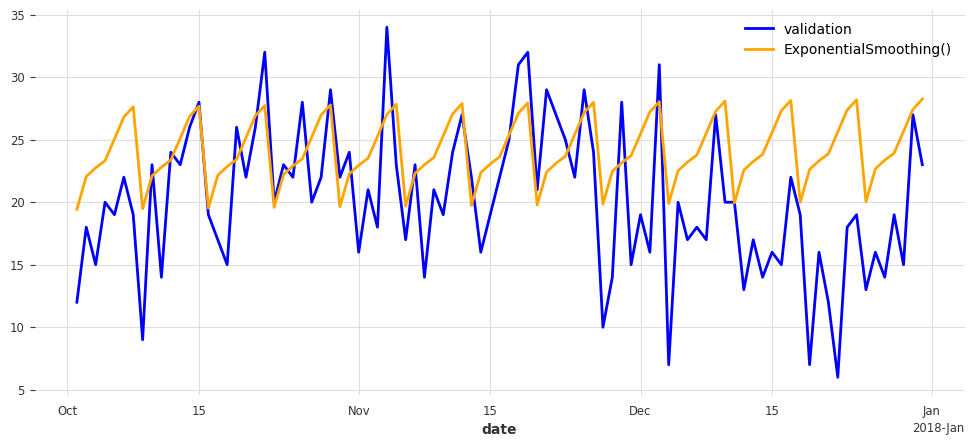

model ExponentialSmoothing() obtains MAPE: 36.15%


In [27]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):

  plt.figure(figsize=(12, 5))
  val.plot(label = 'validation', color = 'blue')
  forecast.plot(label = f'{model}', color = 'orange')
  plt.show()

  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(series_train)
    forecast = model.predict(len(series_val))
    eval_forecast(model, series_val, forecast)


fit_eval_model(ExponentialSmoothing())

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



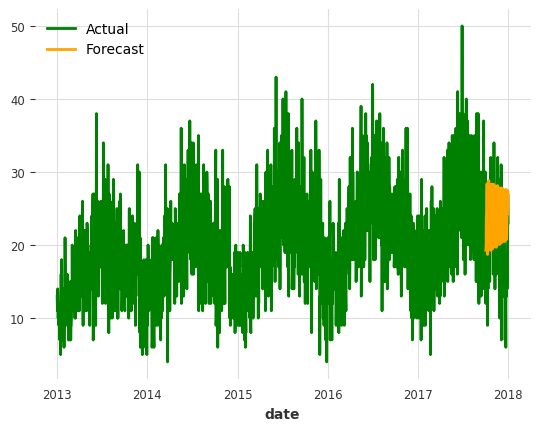

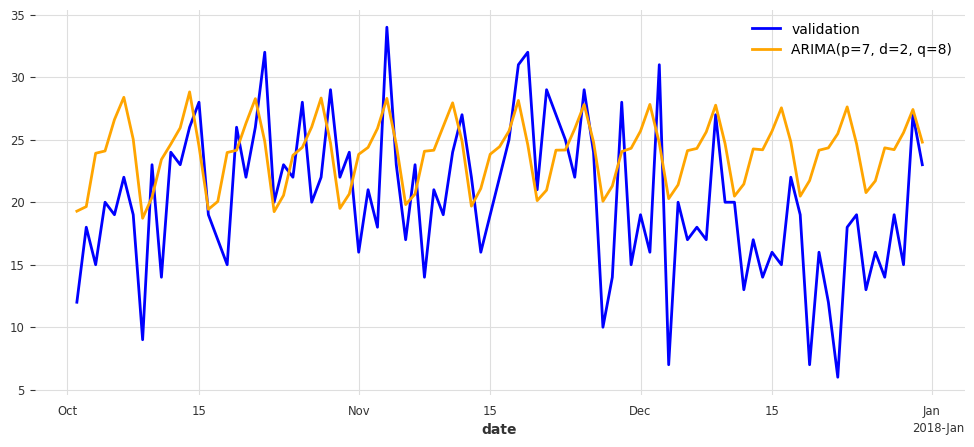

model ARIMA(p=7, d=2, q=8) obtains MAPE: 36.78%


In [28]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual', color = 'green')
  forecast.plot(label='Forecast', color='orange')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=7, d=2, q=8)
fit_and_plot(model, series, series_train, series_val)

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які парaметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, quantiles=None, random_state=None, start_p=7, max_p=12, start_q=1)

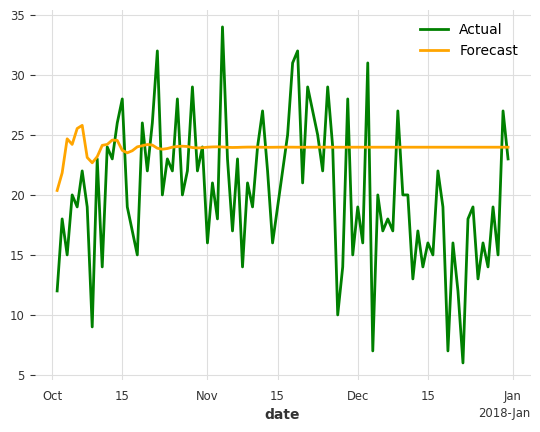

In [29]:
# Побудова та тренування моделі AutoArima
model = AutoARIMA(start_p=7, max_p=12, start_q=1) # спробуйте стартувати з інших значень і перегляньте, що виходить
model.fit(series_train)

display(model)

# Прогнозування
forecast = model.predict(len(series_val))

# Візуалізація результатів
plot_results(series_val, forecast)

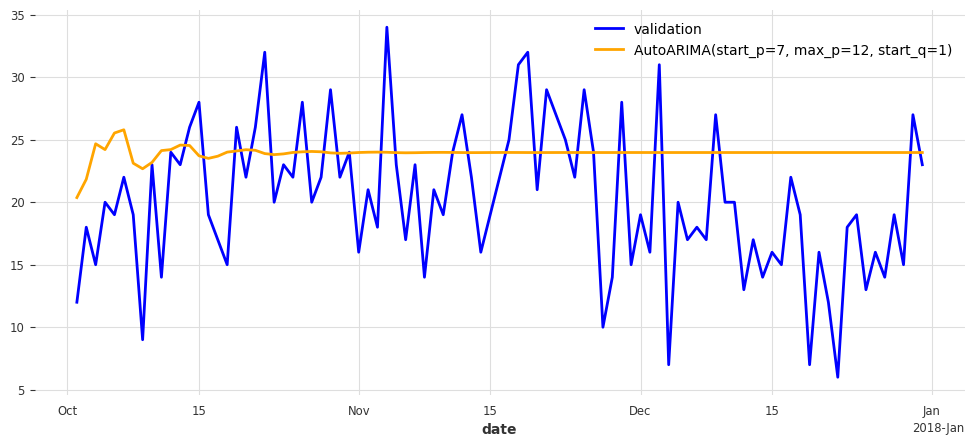

model AutoARIMA(start_p=7, max_p=12, start_q=1) obtains MAPE: 38.56%


In [30]:
eval_forecast(model, series_val, forecast);

**Висновок:**

AutoARIMA підбирає параметри з гіршим результатом, ніж показано в попередньому експерименті з ARIMA.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rwwdts9/qxifpkna.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rwwdts9/9a26deha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=989', 'data', 'file=/tmp/tmp6rwwdts9/qxifpkna.json', 'init=/tmp/tmp6rwwdts9/9a26deha.json', 'output', 'file=/tmp/tmp6rwwdts9/prophet_modelm1tqa0vn/prophet_model-20250831173049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


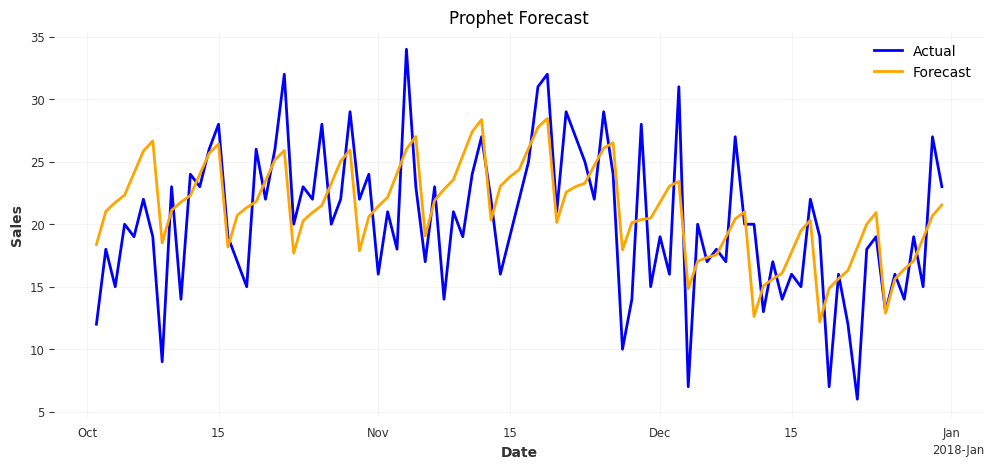

Mean absolute percentage error: 23.67%


In [31]:
import logging
from darts.models import Prophet

# Вимикаємо логування Prophet і CmdStanPy
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# Створюємо і тренуємо модель
model = Prophet(daily_seasonality=False)  # daily_seasonality=True, якщо є щоденна сезонність
model.fit(series_train)

# Прогнозування
forecast = model.predict(len(series_val))

# Візуалізація результатів
plt.figure(figsize=(12,5))
series_val.plot(label='Actual', color='blue')
forecast.plot(label='Forecast', color='orange')
plt.legend()
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.show()

# MAPE
print(f"Mean absolute percentage error: {mape(series_val, forecast):.2f}%")


**Висновок:**

Поки що це найкращий результат, але помилка в більше, ніж 20% все ще висока.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [32]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(series_train)

# Прогнозування
forecast = model.predict(len(series_val))


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean absolute percentage error: 38.80%


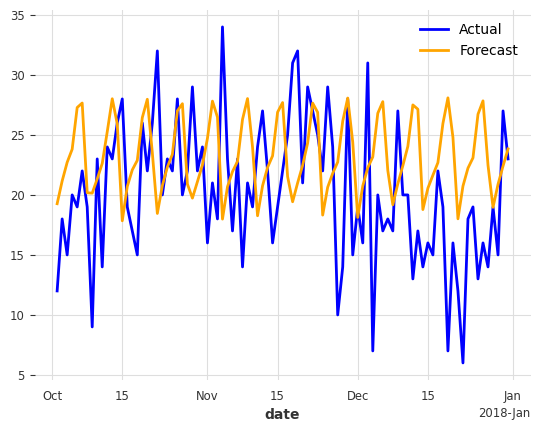

In [33]:
# MAPE
print(f"Mean absolute percentage error: {mape(series_val, forecast):.2f}%")

# Візуалізація результатів
series_val.plot(label='Actual', color = 'blue')
forecast.plot(label='Forecast', color='orange')
plt.legend()
plt.show()

In [34]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Масштабування даних
transformer = Scaler()
train_transformed = transformer.fit_transform(series_train)
val_transformed = transformer.transform(series_val)
series_transformed = transformer.transform(series)

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)

model.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True)

# Прогнозування
forecast = scaler.inverse_transform(model.predict(len(series_val)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean absolute percentage error: 28.33%


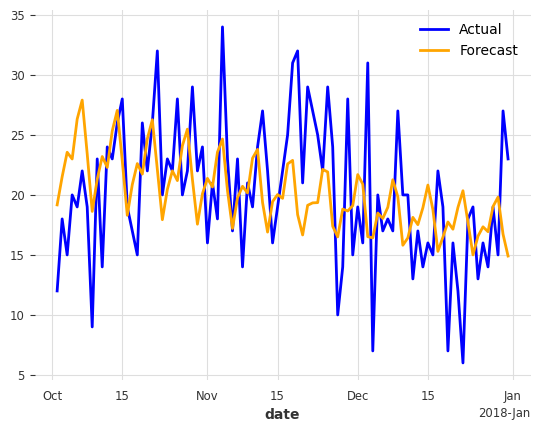

In [35]:
# MAPE
print(f"Mean absolute percentage error: {mape(series_val, forecast):.2f}%")

# Візуалізація результатів
series_val.plot(label='Actual', color = 'blue')
forecast.plot(label='Forecast', color='orange')
plt.legend()
plt.show()

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [ ]:
# наша найкраща модель

from darts.models import Prophet

model = Prophet()
model.fit(series_train)

forecast = model.predict(len(series_val))

eval_forecast(model, series_val, forecast);

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True,  **hfc_params)

Mean absolute percentage error: 20.37%


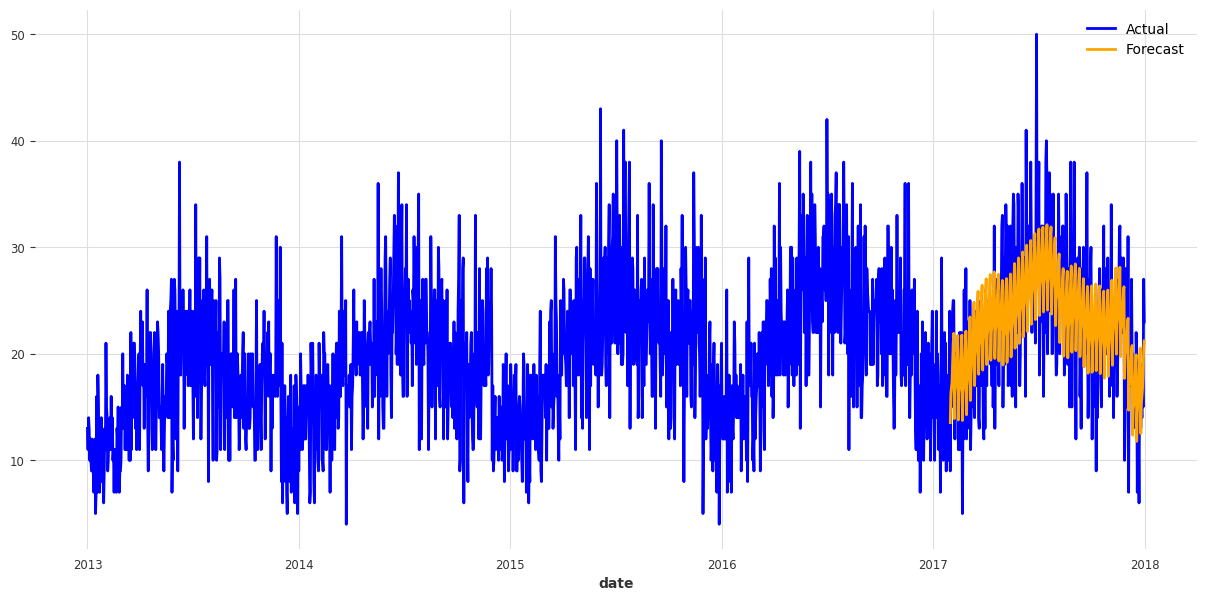

In [42]:
# MAPE
print(f"Mean absolute percentage error: {mape(series, historical_fcast):.2f}%")

# Візуалізація результатів
plt.figure(figsize=(15, 7))
series.plot(label='Actual', color = 'blue')
historical_fcast.plot(label='Forecast', color='orange')
plt.legend()
plt.show()

**Висновок:**

Це найкращий результат з усіх експериментів.

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Спочатку спробувала б модель, яка найкраще себе проявила для першого товару з першого магазину. Якщо помилка виявиться значно вищою, тоді пробувати інші моделі.

Тобто план може бути такий:
1. Прогнати в циклі всі пари магазин-товар і обчислити метрики.
2. Випадки, де значення метрик значно більші, розглядати окремо.
 - визначити в чому полягає відмінність ряду від початково обраної пари
 - спробувати змінити параметри обраної моделі або тренувати іншу модель.